In [1]:
#install dependencies
#!pip install openai --no-deps --target=/kaggle/working/
!npm install localtunnel

m##################] | reify:localtunnel: http fetch GET 200 https://registry.n
changed 1 package, and audited 23 packages in 2s

3 packages are looking for funding
  run `npm fund` for details

2 moderate severity vulnerabilities

To address all issues (including breaking changes), run:
  npm audit fix --force

Run `npm audit` for details.
npm notice 
npm notice New minor version of npm available! 10.1.0 -> 10.8.3
npm notice Changelog: https://github.com/npm/cli/releases/tag/v10.8.3
npm notice Run npm install -g npm@10.8.3 to update!
npm notice 


In [2]:
!pip install streamlit 

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.7/8.7 MB 49.1 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.9/6.9 MB 55.2 MB/s eta 0:00:0000:01:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 82.9/82.9 kB 3.4 MB/s eta 0:00:00


In [3]:
%%writefile app.py
from kaggle_secrets import UserSecretsClient
import streamlit as st
from openai import OpenAI
from langchain import hub
from langchain.agents import ConversationalChatAgent, AgentExecutor
from langchain.agents import create_tool_calling_agent
from langchain.agents import AgentType, initialize_agent, load_tools
from langchain_core.callbacks import Callbacks
from langchain_core.prompts import ChatPromptTemplate
from langchain.callbacks import StreamlitCallbackHandler
from langchain_core.runnables import RunnableConfig
from langchain_community.chat_message_histories import StreamlitChatMessageHistory
from langchain.memory import ConversationBufferMemory
from langchain_community.tools import DuckDuckGoSearchRun

import base64
import requests, io
from PIL import Image
import matplotlib.pyplot as plt
from langchain.tools import BaseTool, StructuredTool, tool, Tool
from langchain.pydantic_v1 import BaseModel, Field
import pyshorteners
import sqlite3

#title = "Project Alpha"
#requirementNum = "UF-A"
#date = "10/03/2023"
#description = "default description"
#systemRequirements = "--"
#justification = "--"
#useCases = "--"
#testCases = "--"
if "htmlcode" not in st.session_state:
    st.session_state.htmlcode = ""
if "umlcode" not in st.session_state:
    st.session_state.umlcode = ""
if "umldiagram" not in st.session_state:
    st.session_state.umldiagram = ""
if "cardmeta" not in st.session_state:
    st.session_state.cardmeta = {}
if "cardmetatc" not in st.session_state:
    st.session_state.cardmetatc = {}
    
    
   
#ADD ERROR HANDLING
def save_requirement():
    #saves requirement info into a sqlite database
    conn = sqlite3.connect('capstoneProject.db')
    sql_upsert = """
    INSERT INTO requirements (title, requirementnum, creation, modification, description, priority, requirements, justification, usecases, testcases)
    VALUES (?, ?, ?, ?, ?, ?, ?, ?, ?, ?)
    ON CONFLICT(requirementnum) DO UPDATE SET
        title = excluded.title,
        creation = excluded.creation,
        modification = excluded.modification,
        description = excluded.description,
        priority = excluded.priority,
        requirements = excluded.requirements,
        justification = excluded.justification,
        usecases = excluded.usecases,
        testcases = excluded.testcases
    """


    # Extract the values from st.session_state.cardmeta
    values_to_insert = (
        st.session_state.cardmeta["title"],
        st.session_state.cardmeta["requirementNum"],
        st.session_state.cardmeta["date"],
        st.session_state.cardmeta["modification"],
        st.session_state.cardmeta["description"],
        st.session_state.cardmeta["priority"],
        st.session_state.cardmeta["relatedRequirements"],
        st.session_state.cardmeta["justification"],
        st.session_state.cardmeta["useCases"],
        st.session_state.cardmeta["testCases"]
    )
    st.session_state.cardmeta = {}
    cur = conn.cursor()
    cur.execute(sql_upsert, values_to_insert)
    
    conn.commit()
    # close the connection to the database
    conn.close()

def save_testcase():
    conn = sqlite3.connect('capstoneProject.db')
    sql_upsert = """
    INSERT INTO tests (title, suite, tcNum, description, testInput, result, userReq, sysReq, useCase)
    VALUES (?, ?, ?, ?, ?, ?, ?, ?, ?)
    ON CONFLICT(tcNum) DO UPDATE SET
        title = excluded.title,
        suite = excluded.suite,
        description = excluded.description,
        testInput = excluded.testInput,
        result = excluded.result,
        userReq = excluded.userReq,
        sysReq = excluded.sysReq,
        useCase = excluded.useCase;
    """
    
    values_to_insert = (
        st.session_state.cardmetatc["title"],
        st.session_state.cardmetatc["suite"],
        st.session_state.cardmetatc["tcNum"],
        st.session_state.cardmetatc["description"],
        st.session_state.cardmetatc["testInput"],
        st.session_state.cardmetatc["result"],
        st.session_state.cardmetatc["userReq"],
        st.session_state.cardmetatc["sysReq"],
        st.session_state.cardmetatc["useCase"],
    )
    
    st.session_state.cardmetatc = {}
    cur = conn.cursor()
    cur.execute(sql_upsert, values_to_insert)
    
    conn.commit()
    conn.close()
    
st.sidebar.html(st.session_state.htmlcode)
text_area_value = st.sidebar.text_area("MermaidJS code", value = st.session_state.umlcode, height = 300)


user_secrets = UserSecretsClient()
secret_value = user_secrets.get_secret("OPENAI_API_KEY")
client = OpenAI(api_key=secret_value)
from langchain_openai import ChatOpenAI
import asyncio
import datetime

model = ChatOpenAI(model="gpt-3.5-turbo", openai_api_key=secret_value, streaming=True) # chose gpt-4-1106-preview for better UML
msgs = StreamlitChatMessageHistory()
memory = ConversationBufferMemory(
    chat_memory=msgs, return_messages=True, memory_key="chat_history", output_key="output"
)
#define Tools##############################################################################
#tools = load_tools(["ddg-search"])

def retrieveTestCase(tcNum: str) -> str:
    """Try to retrieve information on an existing test case in the tests table"""
    conn = sqlite3.connect('capstoneProject.db')
    sql_select = """
    SELECT * FROM tests WHERE tcNum = ?
    """
    cur = conn.cursor()
    # Execute the SELECT statement
    cur.execute(sql_select, (tcNum,))

    # Fetch the result
    row = cur.fetchone()
    if row:
        formatted_result = f'title: "{row[0]}", suite: "{row[1]}", tcNum: "{row[2]}", description: "{row[3]}", testInput: "{row[4]}", result: "{row[5]}", userReq: "{row[6]}", sysReq: "{row[7]}", useCase: "{row[8]}"'
    else:
        formatted_result = 'No data found for the given test number.'
    # close the connection to the database
    conn.close()
    # Print the formatted result
    return formatted_result

class RetrieveTestCaseInput(BaseModel):
    tcNum: str = Field(..., description="The test case number for identification on retrieval")

retrieve_test_case_tool = Tool.from_function(
    func=retrieveTestCase,
    name="RetrieveTestCase",
    description="Retrieves all data related to an existing test case that was saved by the user",
    args_schema=RetrieveTestCaseInput
)

def retrieveRequirement(requirementNum: str) -> str:
    """Try to retrieve information on an existing requirement in the requirements table"""
    conn = sqlite3.connect('capstoneProject.db')
    sql_select = """
    SELECT * FROM requirements WHERE requirementnum = ?
    """
    cur = conn.cursor()
    # Execute the SELECT statement
    cur.execute(sql_select, (requirementNum,))

    # Fetch the result
    row = cur.fetchone()
    if row:
        formatted_result = f'title: "{row[0]}", requirementNum: "{row[1]}", creation: "{row[2]}", modification: "{row[3]}", description: "{row[4]}", priority: "{row[5]}", related requirements: "{row[6]}", justification: "{row[7]}", usecases: "{row[8]}", testcases: "{row[9]}"'
    else:
        formatted_result = 'No data found for the given requirement number.'
    # close the connection to the database
    conn.close()
    # Print the formatted result
    return formatted_result

class RetrieveRequirementInput(BaseModel):
    requirementNum: str = Field(..., description="The requirement number for identification on retrieval")

retrieve_requirement_tool = Tool.from_function(
    func=retrieveRequirement,
    name="RetrieveRequirement",
    description="Retrieves all data related to an existing requirement that was saved by the user",
    args_schema=RetrieveRequirementInput
)

#ADD ERROR HANDLING
def convertToUML(mermaidjs: str) -> str:
    """Convert mermaid.js code to a UML diagram represented as a png url"""
    graph = mermaidjs
    st.session_state.umlcode = graph  #editable sidebar mermaid.js code. 
    graphbytes = graph.encode("ascii")
    base64_bytes = base64.b64encode(graphbytes)
    base64_string = base64_bytes.decode("ascii")
    img = Image.open(io.BytesIO(requests.get('https://mermaid.ink/img/' + base64_string).content))
    png_url = f'https://mermaid.ink/img/{base64_string}'
    st.session_state.umldiagram = png_url
    short_url = pyshorteners.Shortener().tinyurl.short(png_url)
    return short_url
    
class ConvertToUMLInput(BaseModel):
    mermaidjs: str = Field(..., description="The mermaid.js code to convert to UML")

# Create a Tool instance from function
convert_to_uml_tool = Tool.from_function(
    func=convertToUML,
    name="ConvertToUML",
    description="Convert mermaid.js code to a UML diagram as a PNG image",
    args_schema=ConvertToUMLInput
)  

class CreateRequirementInput(BaseModel):
    title: str = Field(..., description = "The title of the project")
    requirementNum: str = Field(..., description = "The name of the requirement: (user functional: UF-, user product: UP-, user organizational = UO-, user external = UE-) followed with a number. Use the format SF-, SP-, SO-, and SE- followed with a number for system requirements.")
    description: str = Field(..., description = "The description of the user or system requirement")
    rRequirements: str = Field(..., description = "Related requirement numbers (optional field)")
    justification: str = Field(..., description = "Justify why this requirement satisfies or covers related requirements (optional field)")

def createRequirement(title: str, requirementNum: str, description: str, rRequirements: str = "-", justification: str = "-") -> str:
    """Creates a user or system requirement card for the user"""

    current_date = datetime.date.today()
    formatted_date = current_date.strftime("%m/%d/%Y")
    date = formatted_date
        
    #rRequirements = "-"
    #justification = "-"
    useCases = "-"
    testCases = "-"
    
    if "U" in requirementNum:
        type1 = "X" if "UF" in requirementNum else " "
        type2 = "X" if "UF" not in requirementNum else " "
        type3 = type4 = " "
        reqVerbiage = "This Req. is Refined Into"
        coverVerbiage = f"Justify why {requirementNum} can be completely covered by {rRequirements}"
    else:    
        type1 = type2 = " "
        type3 = "X" if "SF" in requirementNum else " "
        type4 = "X" if "SF" not in requirementNum else " "
        reqVerbiage = "This Req. is Engineered from"
        coverVerbiage = f"Justify why meeting {requirementNum} can contribute to the fulfillment of {rRequirements}"


    st.session_state.cardmeta = {
        "title": title,
        "requirementNum": requirementNum,
        "date": date,
        "modification": " ",
        "description": description,
        "priority": " ",
        "relatedRequirements": rRequirements,
        "justification": justification,
        "useCases": useCases,
        "testCases": testCases
    }
    
    htmlstring = f"""
    <table class=MsoNormalTable border=1 cellspacing=0 cellpadding=0 width=625
     style='width:468.75pt;border-collapse:collapse;border:none;mso-border-alt:
     solid black .5pt;mso-yfti-tbllook:1184;mso-padding-alt:0in 5.75pt 0in 5.75pt;
     mso-border-insideh:.5pt solid black;mso-border-insidev:.5pt solid black'>
     <tr style='mso-yfti-irow:0;mso-yfti-firstrow:yes'>
      <td width=103 valign=top style='width:77.25pt;border:solid black 1.0pt;
      mso-border-alt:solid black .5pt;background:black;mso-background-themecolor:
      text1;padding:0in 5.75pt 0in 5.75pt'>
      <p class=MsoNormal><span style='color:white;mso-color-alt:windowtext'>Project
      Name</span><o:p></o:p></p>
      </td>
      <td width=522 colspan=6 valign=top style='width:391.5pt;border:solid black 1.0pt;
      border-left:none;mso-border-left-alt:solid black .5pt;mso-border-alt:solid black .5pt;
      background:black;mso-background-themecolor:text1;padding:0in 5.75pt 0in 5.75pt'>
      <p class=MsoNormal><span style='color:white;mso-color-alt:windowtext'>{title}</span><o:p></o:p></p>
      </td>
     </tr>
     <tr style='mso-yfti-irow:1'>
      <td width=103 valign=top style='width:77.25pt;border:solid black 1.0pt;
      border-top:none;mso-border-top-alt:solid black .5pt;mso-border-alt:solid black .5pt;
      background:#D9D9D9;mso-background-themecolor:background1;mso-background-themeshade:
      217;padding:0in 5.75pt 0in 5.75pt'>
      <p class=MsoNormal><span style='color:black;mso-color-alt:windowtext'>Requirement
      #</span><o:p></o:p></p>
      </td>
      <td width=277 colspan=3 valign=top style='width:207.75pt;border-top:none;
      border-left:none;border-bottom:solid black 1.0pt;border-right:solid black 1.0pt;
      mso-border-top-alt:solid black .5pt;mso-border-left-alt:solid black .5pt;
      mso-border-alt:solid black .5pt;background:#D9D9D9;mso-background-themecolor:
      background1;mso-background-themeshade:217;padding:0in 5.75pt 0in 5.75pt'>
      <p class=MsoNormal><a name="_Toc147686350"><span style='color:black;
      mso-color-alt:windowtext'>{requirementNum}</span></a><o:p></o:p></p>
      </td>
      <td width=65 valign=top style='width:48.75pt;border-top:none;border-left:
      none;border-bottom:solid black 1.0pt;border-right:solid black 1.0pt;
      mso-border-top-alt:solid black .5pt;mso-border-left-alt:solid black .5pt;
      mso-border-alt:solid black .5pt;background:#D9D9D9;mso-background-themecolor:
      background1;mso-background-themeshade:217;padding:0in 5.75pt 0in 5.75pt'>
      <p class=MsoNormal><span style='color:black;mso-color-alt:windowtext'>Type</span><o:p></o:p></p>
      </td>
      <td width=89 valign=top style='width:66.5pt;border-top:none;border-left:none;
      border-bottom:solid black 1.0pt;border-right:solid black 1.0pt;mso-border-top-alt:
      solid black .5pt;mso-border-left-alt:solid black .5pt;mso-border-alt:solid black .5pt;
      background:#D9D9D9;mso-background-themecolor:background1;mso-background-themeshade:
      217;padding:0in 5.75pt 0in 5.75pt'>
      <p class=MsoNormal><span style='color:black;mso-color-alt:windowtext'>Functional</span><o:p></o:p></p>
      </td>
      <td width=91 valign=top style='width:68.5pt;border-top:none;border-left:none;
      border-bottom:solid black 1.0pt;border-right:solid black 1.0pt;mso-border-top-alt:
      solid black .5pt;mso-border-left-alt:solid black .5pt;mso-border-alt:solid black .5pt;
      background:#D9D9D9;mso-background-themecolor:background1;mso-background-themeshade:
      217;padding:0in 5.75pt 0in 5.75pt'>
      <p class=MsoNormal><span style='color:black;mso-color-alt:windowtext'>Non-Functional</span><o:p></o:p></p>
      </td>
     </tr>
     <tr style='mso-yfti-irow:2'>
      <td width=103 valign=top style='width:77.25pt;border:solid black 1.0pt;
      border-top:none;mso-border-top-alt:solid black .5pt;mso-border-alt:solid black .5pt;
      background:#D9D9D9;mso-background-themecolor:background1;mso-background-themeshade:
      217;padding:0in 5.75pt 0in 5.75pt'>
      <p class=MsoNormal><span style='color:black;mso-color-alt:windowtext'>Creation</span><o:p></o:p></p>
      </td>
      <td width=277 colspan=3 valign=top style='width:207.75pt;border-top:none;
      border-left:none;border-bottom:solid black 1.0pt;border-right:solid black 1.0pt;
      mso-border-top-alt:solid black .5pt;mso-border-left-alt:solid black .5pt;
      mso-border-alt:solid black .5pt;background:#D9D9D9;mso-background-themecolor:
      background1;mso-background-themeshade:217;padding:0in 5.75pt 0in 5.75pt'>
      <p class=MsoNormal><span style='color:black;mso-color-alt:windowtext'>{date}</span><o:p></o:p></p>
      </td>
      <td width=65 valign=top style='width:48.75pt;border-top:none;border-left:
      none;border-bottom:solid black 1.0pt;border-right:solid black 1.0pt;
      mso-border-top-alt:solid black .5pt;mso-border-left-alt:solid black .5pt;
      mso-border-alt:solid black .5pt;background:#D9D9D9;mso-background-themecolor:
      background1;mso-background-themeshade:217;padding:0in 5.75pt 0in 5.75pt'>
      <p class=MsoNormal><span style='color:black;mso-color-alt:windowtext'>User</span><o:p></o:p></p>
      </td>
      <td width=89 valign=top style='width:66.5pt;border-top:none;border-left:none;
      border-bottom:solid black 1.0pt;border-right:solid black 1.0pt;mso-border-top-alt:
      solid black .5pt;mso-border-left-alt:solid black .5pt;mso-border-alt:solid black .5pt;
      background:#D9D9D9;mso-background-themecolor:background1;mso-background-themeshade:
      217;padding:0in 5.75pt 0in 5.75pt'>
      <p class=MsoNormal><span style='color:black;mso-color-alt:windowtext'>{type1}</span><o:p></o:p></p>
      </td>
      <td width=91 valign=top style='width:68.5pt;border-top:none;border-left:none;
      border-bottom:solid black 1.0pt;border-right:solid black 1.0pt;mso-border-top-alt:
      solid black .5pt;mso-border-left-alt:solid black .5pt;mso-border-alt:solid black .5pt;
      background:#D9D9D9;mso-background-themecolor:background1;mso-background-themeshade:
      217;padding:0in 5.75pt 0in 5.75pt'>
      <p class=MsoNormal><span style='color:black;mso-color-alt:windowtext'>{type2}</span><o:p></o:p></p>
      </td>
     </tr>
     <tr style='mso-yfti-irow:3'>
      <td width=103 valign=top style='width:77.25pt;border:solid black 1.0pt;
      border-top:none;mso-border-top-alt:solid black .5pt;mso-border-alt:solid black .5pt;
      background:#D9D9D9;mso-background-themecolor:background1;mso-background-themeshade:
      217;padding:0in 5.75pt 0in 5.75pt'>
      <p class=MsoNormal><span style='color:black;mso-color-alt:windowtext'>Modification</span><o:p></o:p></p>
      </td>
      <td width=277 colspan=3 valign=top style='width:207.75pt;border-top:none;
      border-left:none;border-bottom:solid black 1.0pt;border-right:solid black 1.0pt;
      mso-border-top-alt:solid black .5pt;mso-border-left-alt:solid black .5pt;
      mso-border-alt:solid black .5pt;background:#D9D9D9;mso-background-themecolor:
      background1;mso-background-themeshade:217;padding:0in 5.75pt 0in 5.75pt'>
      <p class=MsoNormal><o:p>&nbsp;</o:p></p>
      </td>
      <td width=65 valign=top style='width:48.75pt;border-top:none;border-left:
      none;border-bottom:solid black 1.0pt;border-right:solid black 1.0pt;
      mso-border-top-alt:solid black .5pt;mso-border-left-alt:solid black .5pt;
      mso-border-alt:solid black .5pt;background:#D9D9D9;mso-background-themecolor:
      background1;mso-background-themeshade:217;padding:0in 5.75pt 0in 5.75pt'>
      <p class=MsoNormal><span style='color:black;mso-color-alt:windowtext'>System</span><o:p></o:p></p>
      </td>
      <td width=89 valign=top style='width:66.5pt;border-top:none;border-left:none;
      border-bottom:solid black 1.0pt;border-right:solid black 1.0pt;mso-border-top-alt:
      solid black .5pt;mso-border-left-alt:solid black .5pt;mso-border-alt:solid black .5pt;
      background:#D9D9D9;mso-background-themecolor:background1;mso-background-themeshade:
      217;padding:0in 5.75pt 0in 5.75pt'>
      <p class=MsoNormal><span style='color:black;mso-color-alt:windowtext'>{type3}</span><o:p></o:p></p>
      </td>
      <td width=91 valign=top style='width:68.5pt;border-top:none;border-left:none;
      border-bottom:solid black 1.0pt;border-right:solid black 1.0pt;mso-border-top-alt:
      solid black .5pt;mso-border-left-alt:solid black .5pt;mso-border-alt:solid black .5pt;
      background:#D9D9D9;mso-background-themecolor:background1;mso-background-themeshade:
      217;padding:0in 5.75pt 0in 5.75pt'>
      <p class=MsoNormal><span style='color:black;mso-color-alt:windowtext'>{type4}</span><o:p></o:p></p>
      </td>
     </tr>
     <tr style='mso-yfti-irow:4;height:8.6pt'>
      <td width=103 rowspan=2 valign=top style='width:77.25pt;border:solid black 1.0pt;
      border-top:none;mso-border-top-alt:solid black .5pt;mso-border-alt:solid black .5pt;
      background:#D9D9D9;mso-background-themecolor:background1;mso-background-themeshade:
      217;padding:0in 5.75pt 0in 5.75pt;height:8.6pt'>
      <p class=MsoNormal><span style='color:black;mso-color-alt:windowtext'>Description</span><o:p></o:p></p>
      </td>
      <td width=277 colspan=3 rowspan=2 valign=top style='width:207.75pt;
      border-top:none;border-left:none;border-bottom:solid black 1.0pt;border-right:
      solid black 1.0pt;mso-border-top-alt:solid black .5pt;mso-border-left-alt:
      solid black .5pt;mso-border-alt:solid black .5pt;background:#D9D9D9;
      mso-background-themecolor:background1;mso-background-themeshade:217;
      padding:0in 5.75pt 0in 5.75pt;height:8.6pt'>
      <p class=MsoNormal><span style='color:black;mso-color-alt:windowtext'>{description}</span><o:p></o:p></p>
      </td>
      <td width=245 colspan=3 valign=top style='width:183.75pt;border-top:none;
      border-left:none;border-bottom:solid black 1.0pt;border-right:solid black 1.0pt;
      mso-border-top-alt:solid black .5pt;mso-border-left-alt:solid black .5pt;
      mso-border-alt:solid black .5pt;background:#D9D9D9;mso-background-themecolor:
      background1;mso-background-themeshade:217;padding:0in 5.75pt 0in 5.75pt;
      height:8.6pt'>
      <p class=MsoNormal><o:p>&nbsp;</o:p></p>
      </td>
     </tr>
     <tr style='mso-yfti-irow:5;height:6.2pt'>
      <td width=245 colspan=3 valign=top style='width:183.75pt;border-top:none;
      border-left:none;border-bottom:solid black 1.0pt;border-right:solid black 1.0pt;
      mso-border-top-alt:solid black .5pt;mso-border-left-alt:solid black .5pt;
      mso-border-alt:solid black .5pt;background:#D9D9D9;mso-background-themecolor:
      background1;mso-background-themeshade:217;padding:0in 5.75pt 0in 5.75pt;
      height:6.2pt'>
      <p class=MsoNormal><o:p>&nbsp;</o:p></p>
      </td>
     </tr>
     <tr style='mso-yfti-irow:6'>
      <td width=103 valign=top style='width:77.25pt;border:solid black 1.0pt;
      border-top:none;mso-border-top-alt:solid black .5pt;mso-border-alt:solid black .5pt;
      background:#D9D9D9;mso-background-themecolor:background1;mso-background-themeshade:
      217;padding:0in 5.75pt 0in 5.75pt'>
      <p class=MsoNormal><span style='color:black;mso-color-alt:windowtext'>Priority</span><o:p></o:p></p>
      </td>
      <td width=102 valign=top style='width:76.5pt;border-top:none;border-left:
      none;border-bottom:solid black 1.0pt;border-right:solid black 1.0pt;
      mso-border-top-alt:solid black .5pt;mso-border-left-alt:solid black .5pt;
      mso-border-alt:solid black .5pt;background:#D9D9D9;mso-background-themecolor:
      background1;mso-background-themeshade:217;padding:0in 5.75pt 0in 5.75pt'>
      <p class=MsoNormal><span style='color:black;mso-color-alt:windowtext'>Highest
      </span><o:p></o:p></p>
      </td>
      <td width=100 valign=top style='width:75.0pt;border-top:none;border-left:
      none;border-bottom:solid black 1.0pt;border-right:solid black 1.0pt;
      mso-border-top-alt:solid black .5pt;mso-border-left-alt:solid black .5pt;
      mso-border-alt:solid black .5pt;background:#D9D9D9;mso-background-themecolor:
      background1;mso-background-themeshade:217;padding:0in 5.75pt 0in 5.75pt'>
      <p class=MsoNormal><span style='color:black;mso-color-alt:windowtext'>High X</span><o:p></o:p></p>
      </td>
      <td width=75 valign=top style='width:56.25pt;border-top:none;border-left:
      none;border-bottom:solid black 1.0pt;border-right:solid black 1.0pt;
      mso-border-top-alt:solid black .5pt;mso-border-left-alt:solid black .5pt;
      mso-border-alt:solid black .5pt;background:#D9D9D9;mso-background-themecolor:
      background1;mso-background-themeshade:217;padding:0in 5.75pt 0in 5.75pt'>
      <p class=MsoNormal><span style='color:black;mso-color-alt:windowtext'>Medium</span><o:p></o:p></p>
      </td>
      <td width=154 colspan=2 valign=top style='width:115.25pt;border-top:none;
      border-left:none;border-bottom:solid black 1.0pt;border-right:solid black 1.0pt;
      mso-border-top-alt:solid black .5pt;mso-border-left-alt:solid black .5pt;
      mso-border-alt:solid black .5pt;background:#D9D9D9;mso-background-themecolor:
      background1;mso-background-themeshade:217;padding:0in 5.75pt 0in 5.75pt'>
      <p class=MsoNormal><span style='color:black;mso-color-alt:windowtext'>Low</span><o:p></o:p></p>
      </td>
      <td width=91 valign=top style='width:68.5pt;border-top:none;border-left:none;
      border-bottom:solid black 1.0pt;border-right:solid black 1.0pt;mso-border-top-alt:
      solid black .5pt;mso-border-left-alt:solid black .5pt;mso-border-alt:solid black .5pt;
      background:#D9D9D9;mso-background-themecolor:background1;mso-background-themeshade:
      217;padding:0in 5.75pt 0in 5.75pt'>
      <p class=MsoNormal><span style='color:black;mso-color-alt:windowtext'>Lowest</span><o:p></o:p></p>
      </td>
     </tr>
     <tr style='mso-yfti-irow:7'>
      <td width=205 colspan=2 valign=top style='width:153.75pt;border:solid black 1.0pt;
      border-top:none;mso-border-top-alt:solid black .5pt;mso-border-alt:solid black .5pt;
      background:#D9D9D9;mso-background-themecolor:background1;mso-background-themeshade:
      217;padding:0in 5.75pt 0in 5.75pt'>
      <p class=MsoNormal><span style='color:black;mso-color-alt:windowtext'>{reqVerbiage}</span><o:p></o:p></p>
      </td>
      <td width=420 colspan=5 valign=top style='width:315.0pt;border-top:none;
      border-left:none;border-bottom:solid black 1.0pt;border-right:solid black 1.0pt;
      mso-border-top-alt:solid black .5pt;mso-border-left-alt:solid black .5pt;
      mso-border-alt:solid black .5pt;background:#D9D9D9;mso-background-themecolor:
      background1;mso-background-themeshade:217;padding:0in 5.75pt 0in 5.75pt'>
      <p class=MsoNormal><span style='color:black;mso-color-alt:windowtext'>{rRequirements}</span><o:p></o:p></p>
      </td>
     </tr>
     <tr style='mso-yfti-irow:8;height:31.0pt'>
      <td width=205 colspan=2 valign=top style='width:153.75pt;border:solid black 1.0pt;
      border-top:none;mso-border-top-alt:solid black .5pt;mso-border-alt:solid black .5pt;
      background:#D9D9D9;mso-background-themecolor:background1;mso-background-themeshade:
      217;padding:0in 5.75pt 0in 5.75pt;height:31.0pt'>
      <p class=MsoNormal><span style='color:black;mso-color-alt:windowtext'>{coverVerbiage}</span><o:p></o:p></p>
      </td>
      <td width=420 colspan=5 valign=top style='width:315.0pt;border-top:none;
      border-left:none;border-bottom:solid black 1.0pt;border-right:solid black 1.0pt;
      mso-border-top-alt:solid black .5pt;mso-border-left-alt:solid black .5pt;
      mso-border-alt:solid black .5pt;background:#D9D9D9;mso-background-themecolor:
      background1;mso-background-themeshade:217;padding:0in 5.75pt 0in 5.75pt;
      height:31.0pt'>
      <p class=MsoNormal><span style='color:black;mso-color-alt:windowtext'>{justification}</span><o:p></o:p></p>
      </td>
     </tr>
     <tr style='mso-yfti-irow:9;height:17.95pt'>
      <td width=103 rowspan=2 valign=top style='width:77.25pt;border:solid black 1.0pt;
      border-top:none;mso-border-top-alt:solid black .5pt;mso-border-alt:solid black .5pt;
      background:#D9D9D9;mso-background-themecolor:background1;mso-background-themeshade:
      217;padding:0in 5.75pt 0in 5.75pt;height:17.95pt'>
      <p class=MsoNormal><span style='color:black;mso-color-alt:windowtext'>Traceability</span><o:p></o:p></p>
      </td>
      <td width=102 valign=top style='width:76.5pt;border-top:none;border-left:
      none;border-bottom:solid black 1.0pt;border-right:solid black 1.0pt;
      mso-border-top-alt:solid black .5pt;mso-border-left-alt:solid black .5pt;
      mso-border-alt:solid black .5pt;background:#D9D9D9;mso-background-themecolor:
      background1;mso-background-themeshade:217;padding:0in 5.75pt 0in 5.75pt;
      height:17.95pt'>
      <p class=MsoNormal><span style='color:black;mso-color-alt:windowtext'>Use
      cases</span><o:p></o:p></p>
      </td>
      <td width=420 colspan=5 valign=top style='width:315.0pt;border-top:none;
      border-left:none;border-bottom:solid black 1.0pt;border-right:solid black 1.0pt;
      mso-border-top-alt:solid black .5pt;mso-border-left-alt:solid black .5pt;
      mso-border-alt:solid black .5pt;background:#D9D9D9;mso-background-themecolor:
      background1;mso-background-themeshade:217;padding:0in 5.75pt 0in 5.75pt;
      height:17.95pt'>
      <p class=MsoNormal><span style='color:black;mso-color-alt:windowtext'>{useCases}</span><o:p></o:p></p>
      </td>
     </tr>
     <tr style='mso-yfti-irow:10;mso-yfti-lastrow:yes;height:8.95pt'>
      <td width=102 valign=top style='width:76.5pt;border-top:none;border-left:
      none;border-bottom:solid black 1.0pt;border-right:solid black 1.0pt;
      mso-border-top-alt:solid black .5pt;mso-border-left-alt:solid black .5pt;
      mso-border-alt:solid black .5pt;background:#D9D9D9;mso-background-themecolor:
      background1;mso-background-themeshade:217;padding:0in 5.75pt 0in 5.75pt;
      height:8.95pt'>
      <p class=MsoNormal><span style='color:black;mso-color-alt:windowtext'>Test
      cases</span><o:p></o:p></p>
      </td>
      <td width=420 colspan=5 valign=top style='width:315.0pt;border-top:none;
      border-left:none;border-bottom:solid black 1.0pt;border-right:solid black 1.0pt;
      mso-border-top-alt:solid black .5pt;mso-border-left-alt:solid black .5pt;
      mso-border-alt:solid black .5pt;background:#D9D9D9;mso-background-themecolor:
      background1;mso-background-themeshade:217;padding:0in 5.75pt 0in 5.75pt;
      height:8.95pt'>
      <p class=MsoNormal><span style='color:black;mso-color-alt:windowtext'>{testCases}</span><o:p></o:p></p>
      </td>
     </tr>
     <![if !supportMisalignedColumns]>
     <tr height=0>
      <td width=103 style='border:none'></td>
      <td width=102 style='border:none'></td>
      <td width=100 style='border:none'></td>
      <td width=75 style='border:none'></td>
      <td width=65 style='border:none'></td>
      <td width=89 style='border:none'></td>
      <td width=91 style='border:none'></td>
     </tr>
     <![endif]>
    </table>"""
    st.session_state.htmlcode = htmlstring
    return "inform the user to look at the sidebar to see the user requirement card"


        
# Create a Tool instance from your function
create_or_update_requirement_tool = StructuredTool.from_function(
    func=createRequirement,
    name="CreateOrUpdateRequirement",
    description="Creates or updates a user or system requirement card that will be displayed in the app sidebar",
    args_schema=CreateRequirementInput
)  

class CreateTestCaseInput(BaseModel):
    title: str = Field(..., description = "The title of the project")
    suite: str = Field(..., description = "The test suite for the test case being created in form TS-number")
    tcNum: str = Field(..., description = "The test case number test case being created in form TC-number")
    description: str = Field(..., description = "The description of the what to test")
    testInput: str = Field(..., description = "The data input needed for the test")
    result: str = Field(..., description = "The expected test results")
    userReq: str = Field(..., description = "Related user requirements (set as empty string when not provided)")
    sysReq: str = Field(..., description = "Related system requirements (set as empty string when not provided)")


def createTestCase(title: str, suite: str, tcNum: str, description: str, testInput: str, result: str, userReq: str = "-", sysReq: str = "-") -> str:
    """Creates a test case card for the user"""
    useCase = "-"
    
    st.session_state.cardmetatc = {
        "title": title,
        "suite": suite,
        "tcNum": tcNum,
        "description": description,
        "testInput": testInput,
        "result": result,
        "userReq": userReq,  
        "sysReq": sysReq,    
        "useCase": useCase   
    }
    
    
    htmlstring = f"""
    <table class=MsoTable15Grid4 border=1 cellspacing=0 cellpadding=0
     style='border-collapse:collapse;border:none;mso-border-alt:solid #666666 .5pt;
     mso-border-themecolor:text1;mso-border-themetint:153;mso-yfti-tbllook:1184;
     mso-padding-alt:0in 5.4pt 0in 5.4pt'>
     <tr style='mso-yfti-irow:-1;mso-yfti-firstrow:yes;mso-yfti-lastfirstrow:yes;
      height:15.0pt'>
      <td width=96 valign=top style='width:71.75pt;border:solid black 1.0pt;
      mso-border-themecolor:text1;border-right:none;mso-border-top-alt:solid black .5pt;
      mso-border-top-themecolor:text1;mso-border-left-alt:solid black .5pt;
      mso-border-left-themecolor:text1;mso-border-bottom-alt:solid black .5pt;
      mso-border-bottom-themecolor:text1;background:black;mso-background-themecolor:
      text1;padding:0in 5.4pt 0in 5.4pt;height:15.0pt'>
      <p class=MsoNormal style='mso-yfti-cnfc:5'><b><span style='font-size:10.0pt;
      color:white;mso-themecolor:background1'>Project Name<o:p></o:p></span></b></p>
      </td>
      <td width=528 colspan=2 valign=top style='width:395.75pt;border:solid black 1.0pt;
      mso-border-themecolor:text1;border-left:none;mso-border-top-alt:solid black .5pt;
      mso-border-top-themecolor:text1;mso-border-bottom-alt:solid black .5pt;
      mso-border-bottom-themecolor:text1;mso-border-right-alt:solid black .5pt;
      mso-border-right-themecolor:text1;background:black;mso-background-themecolor:
      text1;padding:0in 5.4pt 0in 5.4pt;height:15.0pt'>
      <p class=MsoNormal style='mso-yfti-cnfc:1'><b><span style='font-size:10.0pt;
      color:white;mso-themecolor:background1'>{title}<o:p></o:p></span></b></p>
      </td>
     </tr>
     <tr style='mso-yfti-irow:0;height:15.0pt'>
      <td width=96 valign=top style='width:71.75pt;border:solid #666666 1.0pt;
      border-top:none;mso-border-top-alt:solid #666666 .5pt;mso-border-alt:solid #666666 .5pt;
      background:#CCCCCC;mso-background-themecolor:text1;mso-background-themetint:
      51;padding:0in 5.4pt 0in 5.4pt;height:15.0pt'>
      <p class=MsoNormal style='mso-yfti-cnfc:68'><b><span style='font-size:10.0pt;
      color:black;mso-color-alt:windowtext'>Test Suite</span></b><b><span
      style='font-size:10.0pt'><o:p></o:p></span></b></p>
      </td>
      <td width=528 colspan=2 valign=top style='width:395.75pt;border-top:none;
      border-left:none;border-bottom:solid #666666 1.0pt;border-right:solid #666666 1.0pt;
      mso-border-top-alt:solid #666666 .5pt;mso-border-left-alt:solid #666666 .5pt;
      mso-border-alt:solid #666666 .5pt;background:#CCCCCC;mso-background-themecolor:
      text1;mso-background-themetint:51;padding:0in 5.4pt 0in 5.4pt;height:15.0pt'>
      <p class=MsoNormal style='mso-yfti-cnfc:64'><span style='font-size:10.0pt;
      color:black;mso-color-alt:windowtext'>{suite}</span><span style='font-size:
      10.0pt'><o:p></o:p></span></p>
      </td>
     </tr>
     <tr style='mso-yfti-irow:1;height:15.0pt'>
      <td width=96 valign=top style='width:71.75pt;border:solid #666666 1.0pt;
      border-top:none;mso-border-top-alt:solid #666666 .5pt;mso-border-alt:solid #666666 .5pt;
      padding:0in 5.4pt 0in 5.4pt;height:15.0pt'>
      <p class=MsoNormal style='mso-yfti-cnfc:4'><b><span style='font-size:10.0pt'>Test
      Case ID<o:p></o:p></span></b></p>
      </td>
      <td width=528 colspan=2 valign=top style='width:395.75pt;border-top:none;
      border-left:none;border-bottom:solid #666666 1.0pt;border-right:solid #666666 1.0pt;
      mso-border-top-alt:solid #666666 .5pt;mso-border-left-alt:solid #666666 .5pt;
      mso-border-alt:solid #666666 .5pt;padding:0in 5.4pt 0in 5.4pt;height:15.0pt'>
      <p class=MsoNormal><span style='font-size:10.0pt'>{tcNum}<o:p></o:p></span></p>
      </td>
     </tr>
     <tr style='mso-yfti-irow:2;height:15.0pt'>
      <td width=96 valign=top style='width:71.75pt;border:solid #666666 1.0pt;
      border-top:none;mso-border-top-alt:solid #666666 .5pt;mso-border-alt:solid #666666 .5pt;
      background:#CCCCCC;mso-background-themecolor:text1;mso-background-themetint:
      51;padding:0in 5.4pt 0in 5.4pt;height:15.0pt'>
      <p class=MsoNormal style='mso-yfti-cnfc:68'><b><span style='font-size:10.0pt;
      color:black;mso-color-alt:windowtext'>What to Test</span></b><b><span
      style='font-size:10.0pt'><o:p></o:p></span></b></p>
      </td>
      <td width=528 colspan=2 valign=top style='width:395.75pt;border-top:none;
      border-left:none;border-bottom:solid #666666 1.0pt;border-right:solid #666666 1.0pt;
      mso-border-top-alt:solid #666666 .5pt;mso-border-left-alt:solid #666666 .5pt;
      mso-border-alt:solid #666666 .5pt;background:#CCCCCC;mso-background-themecolor:
      text1;mso-background-themetint:51;padding:0in 5.4pt 0in 5.4pt;height:15.0pt'>
      <p class=MsoNormal style='mso-yfti-cnfc:64'><span style='font-size:10.0pt;
      color:black;mso-color-alt:windowtext'>{description}</span><o:p></o:p></p>
      </td>
     </tr>
     <tr style='mso-yfti-irow:3;height:24.9pt'>
      <td width=96 valign=top style='width:71.75pt;border:solid #666666 1.0pt;
      border-top:none;mso-border-top-alt:solid #666666 .5pt;mso-border-alt:solid #666666 .5pt;
      padding:0in 5.4pt 0in 5.4pt;height:24.9pt'>
      <p class=MsoNormal style='mso-yfti-cnfc:4'><b><span style='font-size:10.0pt'>Test
      Data Input<o:p></o:p></span></b></p>
      </td>
      <td width=528 colspan=2 valign=top style='width:395.75pt;border-top:none;
      border-left:none;border-bottom:solid #666666 1.0pt;border-right:solid #666666 1.0pt;
      mso-border-top-alt:solid #666666 .5pt;mso-border-left-alt:solid #666666 .5pt;
      mso-border-alt:solid #666666 .5pt;padding:0in 5.4pt 0in 5.4pt;height:24.9pt'>
      <p class=MsoNormal><span class=GramE><span style='font-size:10.0pt'>{testInput}<span
      style='mso-spacerun:yes'>  </span>Page</span></span><span style='font-size:
      10.0pt'><o:p></o:p></span></p>
      </td>
     </tr>
     <tr style='mso-yfti-irow:4;height:15.0pt'>
      <td width=96 valign=top style='width:71.75pt;border:solid #666666 1.0pt;
      border-top:none;mso-border-top-alt:solid #666666 .5pt;mso-border-alt:solid #666666 .5pt;
      background:#CCCCCC;mso-background-themecolor:text1;mso-background-themetint:
      51;padding:0in 5.4pt 0in 5.4pt;height:15.0pt'>
      <p class=MsoNormal style='mso-yfti-cnfc:68'><b><span style='font-size:10.0pt;
      color:black;mso-color-alt:windowtext'>Expected</span></b><b><span
      style='font-size:10.0pt'><o:p></o:p></span></b></p>
      <p class=MsoNormal style='mso-yfti-cnfc:68'><b><span style='font-size:10.0pt;
      color:black;mso-color-alt:windowtext'>Result</span></b><span
      style='font-size:10.0pt'><o:p></o:p></span></p>
      </td>
      <td width=528 colspan=2 valign=top style='width:395.75pt;border-top:none;
      border-left:none;border-bottom:solid #666666 1.0pt;border-right:solid #666666 1.0pt;
      mso-border-top-alt:solid #666666 .5pt;mso-border-left-alt:solid #666666 .5pt;
      mso-border-alt:solid #666666 .5pt;background:#CCCCCC;mso-background-themecolor:
      text1;mso-background-themetint:51;padding:0in 5.4pt 0in 5.4pt;height:15.0pt'>
      <p class=MsoNormal style='mso-yfti-cnfc:64'><span style='font-size:10.0pt;
      color:black;mso-color-alt:windowtext'>{result}</span><span
      style='font-size:10.0pt'><o:p></o:p></span></p>
      </td>
     </tr>
     <tr style='mso-yfti-irow:5;height:15.0pt'>
      <td width=96 rowspan=3 valign=top style='width:71.75pt;border-top:none;
      border-left:solid #666666 1.0pt;border-bottom:solid #666666 1.0pt;mso-border-bottom-themecolor:
      text1;mso-border-bottom-themetint:153;border-right:solid #666666 1.0pt;
      mso-border-top-alt:solid #666666 .5pt;mso-border-alt:solid #666666 .5pt;
      mso-border-bottom-alt:solid #666666 .5pt;mso-border-bottom-themecolor:text1;
      mso-border-bottom-themetint:153;padding:0in 5.4pt 0in 5.4pt;height:15.0pt'>
      <p class=MsoNormal style='mso-yfti-cnfc:4'><b><span style='font-size:10.0pt'>Traceability<o:p></o:p></span></b></p>
      </td>
      <td width=156 valign=top style='width:117.0pt;border-top:none;border-left:
      none;border-bottom:solid #666666 1.0pt;border-right:solid #666666 1.0pt;
      mso-border-top-alt:solid #666666 .5pt;mso-border-left-alt:solid #666666 .5pt;
      mso-border-alt:solid #666666 .5pt;padding:0in 5.4pt 0in 5.4pt;height:15.0pt'>
      <p class=MsoNormal><span style='font-size:10.0pt'>Relevant User Req.(s)<o:p></o:p></span></p>
      </td>
      <td width=372 valign=top style='width:278.75pt;border-top:none;border-left:
      none;border-bottom:solid #666666 1.0pt;border-right:solid #666666 1.0pt;
      mso-border-top-alt:solid #666666 .5pt;mso-border-left-alt:solid #666666 .5pt;
      mso-border-alt:solid #666666 .5pt;padding:0in 5.4pt 0in 5.4pt;height:15.0pt'>
      <p class=MsoNormal><span style='font-size:10.0pt'>{userReq}<o:p></o:p></span></p>
      </td>
     </tr>
     <tr style='mso-yfti-irow:6;height:15.0pt'>
      <td width=156 valign=top style='width:117.0pt;border-top:none;border-left:
      none;border-bottom:solid #666666 1.0pt;border-right:solid #666666 1.0pt;
      mso-border-top-alt:solid #666666 .5pt;mso-border-left-alt:solid #666666 .5pt;
      mso-border-alt:solid #666666 .5pt;background:#CCCCCC;mso-background-themecolor:
      text1;mso-background-themetint:51;padding:0in 5.4pt 0in 5.4pt;height:15.0pt'>
      <p class=MsoNormal style='mso-yfti-cnfc:64'><span style='font-size:10.0pt;
      color:black;mso-color-alt:windowtext'>Relevant System Req.(s)</span><span
      style='font-size:10.0pt'><o:p></o:p></span></p>
      </td>
      <td width=372 valign=top style='width:278.75pt;border-top:none;border-left:
      none;border-bottom:solid #666666 1.0pt;border-right:solid #666666 1.0pt;
      mso-border-top-alt:solid #666666 .5pt;mso-border-left-alt:solid #666666 .5pt;
      mso-border-alt:solid #666666 .5pt;background:#CCCCCC;mso-background-themecolor:
      text1;mso-background-themetint:51;padding:0in 5.4pt 0in 5.4pt;height:15.0pt'>
      <p class=MsoNormal style='mso-yfti-cnfc:64'><span style='font-size:10.0pt;
      color:black;mso-color-alt:windowtext'>{sysReq}</span><span style='font-size:
      10.0pt'><o:p></o:p></span></p>
      </td>
     </tr>
     <tr style='mso-yfti-irow:7;mso-yfti-lastrow:yes;height:15.0pt'>
      <td width=156 valign=top style='width:117.0pt;border-top:none;border-left:
      none;border-bottom:solid #666666 1.0pt;border-right:solid #666666 1.0pt;
      mso-border-top-alt:solid #666666 .5pt;mso-border-left-alt:solid #666666 .5pt;
      mso-border-alt:solid #666666 .5pt;padding:0in 5.4pt 0in 5.4pt;height:15.0pt'>
      <p class=MsoNormal><span style='font-size:10.0pt'>Relevant Use <span
      class=GramE>Case.(</span>s)<o:p></o:p></span></p>
      </td>
      <td width=372 valign=top style='width:278.75pt;border-top:none;border-left:
      none;border-bottom:solid #666666 1.0pt;border-right:solid #666666 1.0pt;
      mso-border-top-alt:solid #666666 .5pt;mso-border-left-alt:solid #666666 .5pt;
      mso-border-alt:solid #666666 .5pt;padding:0in 5.4pt 0in 5.4pt;height:15.0pt'>
      <p class=MsoNormal><span style='font-size:10.0pt'>{useCase}<o:p></o:p></span></p>
      </td>
     </tr>
    </table>
    """
    st.session_state.htmlcode = htmlstring
    return "inform the user to look at the sidebar to see the test case card"


create_or_update_testcase_tool = StructuredTool.from_function(
    func=createTestCase,
    name="CreateOrUpdateTestCase",
    description="Creates or updates a test case card that will be displayed in the app sidebar",
    args_schema=CreateTestCaseInput
)  

#End define Tools###########################################################################
#show existing requirements 
conn = sqlite3.connect('capstoneProject.db')
cur = conn.cursor()

cur.execute('SELECT requirementnum FROM requirements')
rows = cur.fetchall()
requirementnums = [row[0] for row in rows]
cur.execute('SELECT tcNum FROM tests')
rows = cur.fetchall()
testcasenums = [row[0] for row in rows]
conn.close()

# Create the selectbox with the requirementnum options


def displayTable():
    conn = sqlite3.connect('capstoneProject.db')
    cur = conn.cursor()
    selected_requirementnum = st.session_state.requirement_selectbox
    cur.execute('SELECT title, creation, modification, description, priority, requirements, justification, usecases, testcases FROM requirements WHERE requirementnum = ?', (selected_requirementnum,))
    data = cur.fetchone()
    title, creation, modification, description, priority, requirements, justification, usecases, testcases = data

    # Call the createRequirement function with the extracted data
    createRequirement(title=title, requirementNum=selected_requirementnum, description=description, rRequirements=requirements, justification=justification)
    st.session_state.cardmeta = {}
    conn.close()

#finish this
def displayTestCase():
    conn = sqlite3.connect('capstoneProject.db')
    cur = conn.cursor()
    selected_tcnum = st.session_state.tc_selectbox
    # Assuming 'testcases' table has the columns that match the parameters of createTestCase
    cur.execute('SELECT title, suite, tcNum, description, testInput, result, userReq, sysReq FROM tests WHERE tcNum = ?', (selected_tcnum,))
    data = cur.fetchone()
    if data:
        # Unpack the data and call createTestCase with the correct arguments
        createTestCase(*data)
    else:
        st.error('Test case not found.')
    st.session_state.cardmetatc = {}    
    conn.close()   
    
st.sidebar.selectbox(
    "Existing Requirements",
    requirementnums,
    key='requirement_selectbox',
    on_change=displayTable)

st.sidebar.selectbox(
    "Existing Test Cases",
    testcasenums,
    key='tc_selectbox',
    on_change=displayTestCase)

if st.session_state.cardmeta:
    st.sidebar.button("Save Requirement Card", on_click=save_requirement)
    
if st.session_state.cardmetatc:
    st.sidebar.button("Save Test Case Card", on_click=save_testcase)

if st.sidebar.button("Update Diagram") and st.session_state.umlcode:
    # Call the function with the text_area value when the button is clicked
    convertToUML(text_area_value)    
    
#def response_generator(prompt):
@st.cache_resource
def run_agent_executor():
    prompt = hub.pull("hwchase17/openai-tools-agent")
    #tools = [where_cat_is_hiding, get_items]
    #agent = create_openai_tools_agent(
    ##    model.with_config({"tags": ["agent_llm"]}), tools, prompt
    #)
    #agent_executor = AgentExecutor(agent=agent, tools=tools).with_config(
    ##    {"run_name": "Agent"}
    #)
    #agent = initialize_agent(
    #    tools, model, agent=AgentType.ZERO_SHOT_REACT_DESCRIPTION, verbose=True
    #)
    #tool_names = ['ddg-search', convert_to_uml_tool]
    #tools = load_tools(["ddg-search"])
    tools = [DuckDuckGoSearchRun(name="Search"), convert_to_uml_tool, create_or_update_requirement_tool, retrieve_requirement_tool, create_or_update_testcase_tool, retrieve_test_case_tool]
    #prompt = hub.pull("hwchase17/react")
    agent = create_tool_calling_agent(model, tools, prompt)
    agent_executor = AgentExecutor(agent=agent, tools=tools, memory=memory, return_intermediate_steps=True, verbose=True)
    return agent_executor
    
    


def main():
    agent_executor = run_agent_executor()
    st.markdown(
        """
       <style>
       [data-testid="stSidebar"][aria-expanded="true"]{
           min-width: 700px;
           max-width: 700px;
       }
       """,
        unsafe_allow_html=True,
    )   

    st.title("Capstone Assistant")

    # Initialize chat history
    if "messages" not in st.session_state:
        st.session_state.messages = []
        
    if "openai_model" not in st.session_state:
        st.session_state["openai_model"] = "gpt-3.5-turbo"
        
    if len(msgs.messages) == 0 or st.sidebar.button("Reset chat history"):
        image_url = '/kaggle/input/memegif/8rpk8a.gif'  # replace with your image URL
        st.image(image_url, width=260)
        msgs.clear()
        st.session_state.steps = {}   
    # Display chat messages from history on app rerun
    #for message in st.session_state.messages:
    #    with st.chat_message(message["role"]):
    #        st.markdown(message["content"])
    avatars = {"human": "user", "ai": "assistant"}
    for idx, msg in enumerate(msgs.messages):
        with st.chat_message(avatars[msg.type]):
            # Render intermediate steps if any were saved
            for step in st.session_state.steps.get(str(idx), []):
                if step[0].tool == "_Exception":
                    continue
                with st.status(f"**{step[0].tool}**: {step[0].tool_input}", state="complete"):
                    st.write(step[0].log)
                    st.write(step[1])
            st.write(msg.content)
            
    if st.session_state.umldiagram:
        st.image(st.session_state.umldiagram)
        st.session_state.umldiagram = ""
    # React to user input
    if prompt := st.chat_input("What is up?"):
        # Display user message in chat message container
        st.chat_message("user").write(prompt)
        # Add user message to chat history
        st.session_state.messages.append({"role": "user", "content": prompt})

        # Display assistant response in chat message container
        with st.chat_message("assistant"):
            #stream = client.chat.completions.create(
            #    model=st.session_state["openai_model"],
            #    messages=[
            #        {"role": m["role"], "content": m["content"]}
            #        for m in st.session_state.messages
            #    ],
            #    stream=True,
            #)
            #st_callback = StreamlitCallbackHandler(st.container())
            #response = agent_exe.invoke(prompt, callbacks=[st_callback])
            #st.write(response)
            
            #st_cb = StreamlitCallbackHandler(st.container(), expand_new_thoughts=False)
            #cfg = RunnableConfig()
            ##cfg["callbacks"] = [st_cb]
            #response = agent_exe.invoke(prompt, cfg)
            #st.write(response["output"])
            #st.session_state.steps[str(len(msgs.messages) - 1)] = response["intermediate_steps"]
            
            st_callback = StreamlitCallbackHandler(st.container())
            response = agent_executor.invoke(
                {"input": prompt}, {"callbacks": [st_callback]}
            )
            st.write(response["output"])
            st.session_state.steps[str(len(msgs.messages) - 1)] = response["intermediate_steps"]
 
            st.experimental_rerun()
        #st.session_state.messages.append({"role": "assistant", "content": response["output"]})
        
            #print(chunk)
            #print("----")
        # Add assistant response to chat history

if __name__ == "__main__":
    main()

Overwriting app.py


In [4]:
!curl ipv4.icanhazip.com

34.83.180.174


In [5]:
!streamlit run app.py &>./logs.txt & npx localtunnel --port 8501

your url is: https://eleven-guests-poke.loca.lt
^C


In [3]:
!pip install -U langchain-openai

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.7/49.7 kB 2.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 310.2/310.2 kB 11.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 320.7/320.7 kB 14.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 36.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 124.4/124.4 kB 6.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.0/53.0 kB 2.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 142.5/142.5 kB 7.0 MB/s eta 0:00:00
  Attempting uninstall: packaging
    Found existing installation: packaging 21.3
    Uninstalling packaging-21.3:
      Successfully uninstalled packaging-21.3
  Attempting uninstall: orjson
    Found existing installation: orjson 3.9.10
    Uninstalling orjson-3.9.10:
      Successfully uninstalled orjson-3.9.10
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is th

In [5]:
!pip install -U langchain-community
!pip install -U duckduckgo-search

In [10]:
!pip install langchain

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 973.5/973.5 kB 14.7 MB/s eta 0:00:0000:01


In [3]:
!pip install langchain langchain-text-splitters --no-deps --target=/kaggle/working/

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 973.5/973.5 kB 14.2 MB/s eta 0:00:00a 0:00:01


Legacy Code for Agents


In [4]:
# experimentation with langchain agents
from kaggle_secrets import UserSecretsClient
import os
user_secrets = UserSecretsClient()
secret_value = user_secrets.get_secret("OPENAI_API_KEY")

os.environ["OPENAI_API_KEY"] = secret_value

from langchain_openai import ChatOpenAI

model = ChatOpenAI(model="gpt-3.5-turbo", streaming=True)

In [6]:
from langchain_core.messages import HumanMessage

response = model.invoke([HumanMessage(content="what is the the mass of the earth")])
response.content

'The mass of the Earth is approximately 5.972 × 10^24 kilograms.'

In [13]:
from langchain import LLMMathChain
from langchain.agents import initialize_agent, Tool
llm_math_chain = LLMMathChain.from_llm(llm=model, verbose=True)

tools = [
    Tool(
        name="Calculator",
        func=llm_math_chain.run,
        description="useful for when you need to answer questions about math"
    )
]

model_with_tools = model.bind_tools(tools)



In [20]:
template = """You are a professional software engineer. Answer the following questions as best you can. Be as helpful as possible. You have access to the following tools:

{tools}

Use the following format:

Question: the input question you must answer
Thought: you should always think about what to do
Action: the action to take, should be one of [{tool_names}]
Action Input: the input to the action
Observation: the result of the action
... (this Thought/Action/Action Input/Observation can repeat N times)
Thought: I now know the final answer
Final Answer: the final answer to the original input question

Begin!

Question: {input}
{agent_scratchpad}"""

In [34]:
from langchain.prompts import BaseChatPromptTemplate, ChatPromptTemplate
from typing import List, Union
import re
# Set up a prompt template
class CustomPromptTemplate(BaseChatPromptTemplate):
    # The template to use
    template: str
    # The list of tools available
    tools: List[Tool]
    
    def format_messages(self, **kwargs) -> str:
        # Get the intermediate steps (AgentAction, Observation tuples)
        
        # Format them in a particular way
        intermediate_steps = kwargs.pop("intermediate_steps")
        thoughts = ""
        for action, observation in intermediate_steps:
            thoughts += action.log
            thoughts += f"\nObservation: {observation}\nThought: "
            
        # Set the agent_scratchpad variable to that value
        kwargs["agent_scratchpad"] = thoughts
        
        # Create a tools variable from the list of tools provided
        kwargs["tools"] = "\n".join([f"{tool.name}: {tool.description}" for tool in self.tools])
        
        # Create a list of tool names for the tools provided
        kwargs["tool_names"] = ", ".join([tool.name for tool in self.tools])
        formatted = self.template.format(**kwargs)
        return [HumanMessage(content=formatted)]
    
prompt = CustomPromptTemplate(
    template=template,
    tools=tools,
    # This omits the `agent_scratchpad`, `tools`, and `tool_names` variables because those are generated dynamically
    # This includes the `intermediate_steps` variable because that is needed
    input_variables=["input", "intermediate_steps"]
)

In [35]:
from langchain.schema import AgentAction, AgentFinish, HumanMessage, SystemMessage
class CustomOutputParser(AgentOutputParser):
    
    def parse(self, llm_output: str) -> Union[AgentAction, AgentFinish]:
        
        # Check if agent should finish
        if "Final Answer:" in llm_output:
            return AgentFinish(
                # Return values is generally always a dictionary with a single `output` key
                # It is not recommended to try anything else at the moment :)
                return_values={"output": llm_output.split("Final Answer:")[-1].strip()},
                log=llm_output,
            )
        
        # Parse out the action and action input
        regex = r"Action: (.*?)[\n]*Action Input:[\s]*(.*)"
        match = re.search(regex, llm_output, re.DOTALL)
        
        # If it can't parse the output it raises an error
    
        if not match:
            raise ValueError(f"Could not parse LLM output: `{llm_output}`")
        action = match.group(1).strip()
        action_input = match.group(2)
        
        # Return the action and action input
        return AgentAction(tool=action, tool_input=action_input.strip(" ").strip('"'), log=llm_output)
    
output_parser = CustomOutputParser()

In [36]:
from langchain.agents import Tool, AgentExecutor, LLMSingleActionAgent, AgentOutputParser
from langchain import LLMChain
llm_chain = LLMChain(llm=model,prompt=prompt)

# Using tools, the LLM chain and output_parser to make an agent
tool_names = [tool.name for tool in tools]

agent = LLMSingleActionAgent(
    llm_chain=llm_chain, 
    output_parser=output_parser,
    # We use "Observation" as our stop sequence so it will stop when it receives Tool output
    # If you change your prompt template you'll need to adjust this as well
    stop=["\nObservation:"], 
    allowed_tools=tool_names
)
agent_executor = AgentExecutor.from_agent_and_tools(agent=agent, tools=tools, verbose=True)

In [39]:
agent_executor.run("what is 57*14234?")



> Entering new AgentExecutor chain...
Thought: I should use the Calculator tool to multiply 57 by 14234
Action: Calculator
Action Input: 57 * 14234

> Entering new LLMMathChain chain...
57 * 14234```text
57 * 14234
```
...numexpr.evaluate("57 * 14234")...

Answer: 811338
> Finished chain.


Observation:Answer: 811338
I now know the final answer
Final Answer: 811338

> Finished chain.


'811338'

THE FOLLOWING IS ANOTHER EXPERIMENT TO ALLOW FOR STREAMING OUTPUTS

In [9]:
from langchain import hub
from langchain.agents import AgentExecutor, create_openai_tools_agent
from langchain.tools import tool
from langchain_core.callbacks import Callbacks
from langchain_core.prompts import ChatPromptTemplate


In [ ]:
#model = ChatOpenAI(temperature=0, streaming=True)

In [10]:
import random

@tool
async def where_cat_is_hiding() -> str:
    """Where is the cat hiding right now?"""
    return random.choice(["under the bed", "on the shelf"])
@tool
async def get_items(place: str) -> str:
    """Use this tool to look up which items are in the given place."""
    if "bed" in place:  # For under the bed
        return "socks, shoes and dust bunnies"
    if "shelf" in place:  # For 'shelf'
        return "books, penciles and pictures"
    else:  # if the agent decides to ask about a different place
        return "cat snacks"

In [7]:
!pip install langchainhub==0.1.16 types-requests==2.32.0.20240523 urllib3==2.1.0 --no-deps --target=/kaggle/working/

  Using cached langchainhub-0.1.16-py3-none-any.whl.metadata (621 bytes)
  Using cached types_requests-2.32.0.20240523-py3-none-any.whl.metadata (1.8 kB)
  Using cached urllib3-2.1.0-py3-none-any.whl.metadata (6.4 kB)
Using cached langchainhub-0.1.16-py3-none-any.whl (4.8 kB)
Using cached types_requests-2.32.0.20240523-py3-none-any.whl (15 kB)
Using cached urllib3-2.1.0-py3-none-any.whl (104 kB)


In [14]:
prompt = hub.pull("hwchase17/openai-tools-agent")
#print(prompt) #-- to see the prompt
tools = [where_cat_is_hiding, get_items]
agent = create_openai_tools_agent(
    model.with_config({"tags": ["agent_llm"]}), tools, prompt
)
agent_executor = AgentExecutor(agent=agent, tools=tools).with_config(
    {"run_name": "Agent"}
)

In [15]:
async for event in agent_executor.astream_events(
    {"input": "where is the cat hiding? what items are in that location?"},
    version="v1",
):
    kind = event["event"]
    if kind == "on_chain_start":
        if (
            event["name"] == "Agent"
        ):  # Was assigned when creating the agent with `.with_config({"run_name": "Agent"})`
            print(
                f"Starting agent: {event['name']} with input: {event['data'].get('input')}"
            )
    elif kind == "on_chain_end":
        if (
            event["name"] == "Agent"
        ):  # Was assigned when creating the agent with `.with_config({"run_name": "Agent"})`
            print()
            print("--")
            print(
                f"Done agent: {event['name']} with output: {event['data'].get('output')['output']}"
            )
    if kind == "on_chat_model_stream":
        content = event["data"]["chunk"].content
        if content:
            # Empty content in the context of OpenAI means
            # that the model is asking for a tool to be invoked.
            # So we only print non-empty content
            print(content, end="")
    elif kind == "on_tool_start":
        print("--")
        print(
            f"Starting tool: {event['name']} with inputs: {event['data'].get('input')}"
        )
    elif kind == "on_tool_end":
        print(f"Done tool: {event['name']}")
        print(f"Tool output was: {event['data'].get('output')}")
        print("--")

Starting agent: Agent with input: {'input': 'where is the cat hiding? what items are in that location?'}
--
Starting tool: where_cat_is_hiding with inputs: {}
Done tool: where_cat_is_hiding
Tool output was: under the bed
--
--
Starting tool: get_items with inputs: {'place': 'under the bed'}
Done tool: get_items
Tool output was: socks, shoes and dust bunnies
--
The cat is hiding under the bed. In that location, you can find socks, shoes, and dust bunnies.
--
Done agent: Agent with output: The cat is hiding under the bed. In that location, you can find socks, shoes, and dust bunnies.


In [40]:
import base64
import requests, io
from PIL import Image
import matplotlib.pyplot as plt
from langchain.tools import BaseTool, StructuredTool, tool
@tool
def convertToUML(mermaidjs: str) -> str:
    """Convert mermaid.js code to a UML diagram represented as a png"""
    graph = mermaidjs
    graphbytes = graph.encode("ascii")
    base64_bytes = base64.b64encode(graphbytes)
    base64_string = base64_bytes.decode("ascii")
    img = Image.open(io.BytesIO(requests.get('https://mermaid.ink/img/' + base64_string).content))
    buffer = io.BytesIO()
    
    
    plt.axis('off')  
    plt.imshow(img)
    plt.savefig(buffer, format='png', bbox_inches='tight')
    
    
    buffer.seek(0)
    
    # Encode the image in base64 and return it
    img_base64 = base64.b64encode(buffer.read())
    buffer.close()
    
    # Convert bytes to string
    img_str = img_base64.decode('ascii')
    
    return img_str
print(convertToUML.name)
print(convertToUML.description)
print(convertToUML.args)

convertToUML
Convert mermaid.js code to a UML diagram represented as a png
{'mermaidjs': {'title': 'Mermaidjs', 'type': 'string'}}


https://tinyurl.com/2c3vgtsy


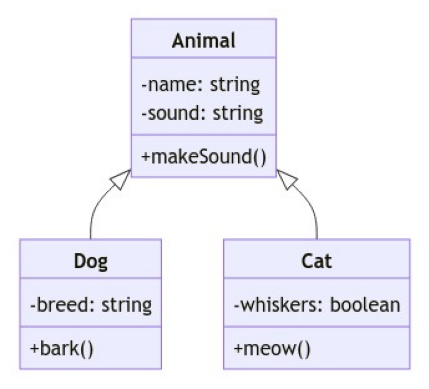

In [13]:
import base64
graph = """
classDiagram
    class Animal {
        -name: string
        -sound: string
        +makeSound()
    }
    class Dog {
        -breed: string
        +bark()
    }
    class Cat {
        -whiskers: boolean
        +meow()
    }
    Animal <|-- Dog
    Animal <|-- Cat
"""
graphbytes = graph.encode("ascii")



base64_bytes = base64.b64encode(graphbytes)
base64_string = base64_bytes.decode("ascii")

import requests, io
from PIL import Image
import matplotlib.pyplot as plt

img = Image.open(io.BytesIO(requests.get('https://mermaid.ink/img/' + base64_string).content))
plt.axis('off')  
plt.imshow(img)
import pyshorteners
png_url = f'https://mermaid.ink/img/{base64_string}'
short_url = pyshorteners.Shortener().tinyurl.short(png_url)
print(short_url)

In [55]:
def convertToUML(mermaidjs: str) -> str:
    """Convert mermaid.js code to a UML diagram represented as a png"""
    graph = mermaidjs
    graphbytes = graph.encode("ascii")
    base64_bytes = base64.b64encode(graphbytes)
    base64_string = base64_bytes.decode("ascii")
    img = Image.open(io.BytesIO(requests.get('https://mermaid.ink/img/' + base64_string).content))
    #buffer = io.BytesIO()
    
    png_url = f'https://mermaid.ink/img/{base64_string}'

    return png_url
    
    #plt.axis('off')  # This will remove the axes
    #plt.imshow(img)
    #plt.savefig(buffer, format='png', bbox_inches='tight')
    #
    # Reset buffer position to the beginning
   # buffer.seek(0)
    
    # Encode the image in base64 and return it
    #img_base64 = base64.b64encode(buffer.read())
    #buffer.close()
    
    # Convert bytes to string
    #img_str = img_base64.decode('ascii')
    
    #return img_str
graph = """
classDiagram
    class Animal {
        -name: string
        -sound: string
        +makeSound()
    }
    class Dog {
        -breed: string
        +bark()
    }
    class Cat {
        -whiskers: boolean
        +meow()
    }
    Animal <|-- Dog
    Animal <|-- Cat
"""
s = convertToUML(graph)
print(s)

https://mermaid.ink/img/CmNsYXNzRGlhZ3JhbQogICAgY2xhc3MgQW5pbWFsIHsKICAgICAgICAtbmFtZTogc3RyaW5nCiAgICAgICAgLXNvdW5kOiBzdHJpbmcKICAgICAgICArbWFrZVNvdW5kKCkKICAgIH0KICAgIGNsYXNzIERvZyB7CiAgICAgICAgLWJyZWVkOiBzdHJpbmcKICAgICAgICArYmFyaygpCiAgICB9CiAgICBjbGFzcyBDYXQgewogICAgICAgIC13aGlza2VyczogYm9vbGVhbgogICAgICAgICttZW93KCkKICAgIH0KICAgIEFuaW1hbCA8fC0tIERvZwogICAgQW5pbWFsIDx8LS0gQ2F0Cg==


In [6]:
#tool for generating Requirements 
#def createRequirementCard(mermaidjs: str) -> str:
#    """Convert mermaid.js code to a UML diagram represented as a png"""



In [9]:
!pip install great_tables

In [14]:
import pandas as pd
import numpy as np

# Create a DataFrame with 9 rows and 6 columns
# Using np.random.rand to generate random numbers for the DataFrame
df = pd.DataFrame(np.random.rand(9, 6), columns=['A', 'B', 'C', 'D', 'E', 'F'])

# Display the DataFrame
print(df)

          A         B         C         D         E         F
0  0.238051  0.674757  0.146463  0.722004  0.576369  0.217056
1  0.670576  0.895497  0.078343  0.053339  0.780375  0.001791
2  0.568260  0.908311  0.644135  0.830042  0.106113  0.842604
3  0.799696  0.922381  0.578880  0.132169  0.193350  0.603617
4  0.843660  0.463572  0.853726  0.190045  0.264665  0.044504
5  0.597651  0.917578  0.083180  0.735598  0.951381  0.277512
6  0.141377  0.765798  0.276034  0.041293  0.198765  0.390162
7  0.984441  0.611533  0.073522  0.312718  0.332542  0.845978
8  0.940572  0.765144  0.350074  0.506761  0.659759  0.214619


In [44]:
import pandas as pd

# Define the data as a dictionary
data = {
    'Requirement #': ['SE-07-06'],
    'Creation': ['October 05, 2023'],
    'Modification': [''],
    'Description': ['The system will translate results into the correct language.'],
    'Priority': ['Highest, High, Medium, Low, Lowest'],
    'Type': ['Functional, NonFunctional'],

    'Created By': ['User'],
    'Last Modification': ['System'],


    'Engineered From': ['UE-07'],
    'Justification for SE-07-06': ['This requirement ensures that translations cover all possible text on ----'],
    'Traceability': ['Use cases UC-002, Test cases TC-063']
}

# Create the DataFrame
df = pd.DataFrame(data)

# Display the DataFrame
df




,Requirement #,Creation,Modification,Description,Priority,Type,Created By,Last Modification,Engineered From,Justification for SE-07-06,Traceability
0,SE-07-06,"October 05, 2023",,The system will translate results into the cor...,"Highest, High, Medium, Low, Lowest","Functional, NonFunctional",User,System,UE-07,This requirement ensures that translations cov...,"Use cases UC-002, Test cases TC-063"


In [1]:

from great_tables import GT
import pandas as pd

# Assuming `df` is your DataFrame from the previous step
df_t = df.T.reset_index()
df_t.columns = ['Project Name', 'Valorium']



df_t
# Create a display table based on the DataFrame
#gt_table = (
##    GT(df_t)
#    .tab_header(title="Project Requirement Card")

#)

# Render the table in the console or a notebook environment
#gt_table

ModuleNotFoundError: No module named 'great_tables'

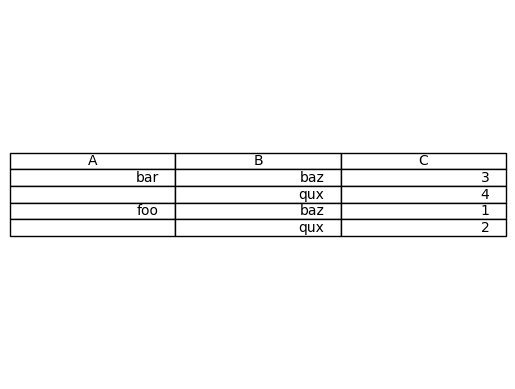

In [121]:

title = "Project Alpha"
requirementNum = "UF-A"
date = "10/03/2023"
description = "default description"
systemRequirements = "--"
justification = "--"
useCases = "--"
testCases = "--"
htmlstring = f"""
<table class=MsoNormalTable border=1 cellspacing=0 cellpadding=0 width=625
 style='width:468.75pt;border-collapse:collapse;border:none;mso-border-alt:
 solid black .5pt;mso-yfti-tbllook:1184;mso-padding-alt:0in 5.75pt 0in 5.75pt;
 mso-border-insideh:.5pt solid black;mso-border-insidev:.5pt solid black'>
 <tr style='mso-yfti-irow:0;mso-yfti-firstrow:yes'>
  <td width=103 valign=top style='width:77.25pt;border:solid black 1.0pt;
  mso-border-alt:solid black .5pt;background:black;mso-background-themecolor:
  text1;padding:0in 5.75pt 0in 5.75pt'>
  <p class=MsoNormal><span style='color:white;mso-color-alt:windowtext'>Project
  Name</span><o:p></o:p></p>
  </td>
  <td width=522 colspan=6 valign=top style='width:391.5pt;border:solid black 1.0pt;
  border-left:none;mso-border-left-alt:solid black .5pt;mso-border-alt:solid black .5pt;
  background:black;mso-background-themecolor:text1;padding:0in 5.75pt 0in 5.75pt'>
  <p class=MsoNormal><span style='color:white;mso-color-alt:windowtext'>{title}</span><o:p></o:p></p>
  </td>
 </tr>
 <tr style='mso-yfti-irow:1'>
  <td width=103 valign=top style='width:77.25pt;border:solid black 1.0pt;
  border-top:none;mso-border-top-alt:solid black .5pt;mso-border-alt:solid black .5pt;
  background:#D9D9D9;mso-background-themecolor:background1;mso-background-themeshade:
  217;padding:0in 5.75pt 0in 5.75pt'>
  <p class=MsoNormal><span style='color:black;mso-color-alt:windowtext'>Requirement
  #</span><o:p></o:p></p>
  </td>
  <td width=277 colspan=3 valign=top style='width:207.75pt;border-top:none;
  border-left:none;border-bottom:solid black 1.0pt;border-right:solid black 1.0pt;
  mso-border-top-alt:solid black .5pt;mso-border-left-alt:solid black .5pt;
  mso-border-alt:solid black .5pt;background:#D9D9D9;mso-background-themecolor:
  background1;mso-background-themeshade:217;padding:0in 5.75pt 0in 5.75pt'>
  <p class=MsoNormal><a name="_Toc147686350"><span style='color:black;
  mso-color-alt:windowtext'>{requirementNum}</span></a><o:p></o:p></p>
  </td>
  <td width=65 valign=top style='width:48.75pt;border-top:none;border-left:
  none;border-bottom:solid black 1.0pt;border-right:solid black 1.0pt;
  mso-border-top-alt:solid black .5pt;mso-border-left-alt:solid black .5pt;
  mso-border-alt:solid black .5pt;background:#D9D9D9;mso-background-themecolor:
  background1;mso-background-themeshade:217;padding:0in 5.75pt 0in 5.75pt'>
  <p class=MsoNormal><span style='color:black;mso-color-alt:windowtext'>Type</span><o:p></o:p></p>
  </td>
  <td width=89 valign=top style='width:66.5pt;border-top:none;border-left:none;
  border-bottom:solid black 1.0pt;border-right:solid black 1.0pt;mso-border-top-alt:
  solid black .5pt;mso-border-left-alt:solid black .5pt;mso-border-alt:solid black .5pt;
  background:#D9D9D9;mso-background-themecolor:background1;mso-background-themeshade:
  217;padding:0in 5.75pt 0in 5.75pt'>
  <p class=MsoNormal><span style='color:black;mso-color-alt:windowtext'>Functional</span><o:p></o:p></p>
  </td>
  <td width=91 valign=top style='width:68.5pt;border-top:none;border-left:none;
  border-bottom:solid black 1.0pt;border-right:solid black 1.0pt;mso-border-top-alt:
  solid black .5pt;mso-border-left-alt:solid black .5pt;mso-border-alt:solid black .5pt;
  background:#D9D9D9;mso-background-themecolor:background1;mso-background-themeshade:
  217;padding:0in 5.75pt 0in 5.75pt'>
  <p class=MsoNormal><span style='color:black;mso-color-alt:windowtext'>Non-Functional</span><o:p></o:p></p>
  </td>
 </tr>
 <tr style='mso-yfti-irow:2'>
  <td width=103 valign=top style='width:77.25pt;border:solid black 1.0pt;
  border-top:none;mso-border-top-alt:solid black .5pt;mso-border-alt:solid black .5pt;
  background:#D9D9D9;mso-background-themecolor:background1;mso-background-themeshade:
  217;padding:0in 5.75pt 0in 5.75pt'>
  <p class=MsoNormal><span style='color:black;mso-color-alt:windowtext'>Creation</span><o:p></o:p></p>
  </td>
  <td width=277 colspan=3 valign=top style='width:207.75pt;border-top:none;
  border-left:none;border-bottom:solid black 1.0pt;border-right:solid black 1.0pt;
  mso-border-top-alt:solid black .5pt;mso-border-left-alt:solid black .5pt;
  mso-border-alt:solid black .5pt;background:#D9D9D9;mso-background-themecolor:
  background1;mso-background-themeshade:217;padding:0in 5.75pt 0in 5.75pt'>
  <p class=MsoNormal><span style='color:black;mso-color-alt:windowtext'>{date}</span><o:p></o:p></p>
  </td>
  <td width=65 valign=top style='width:48.75pt;border-top:none;border-left:
  none;border-bottom:solid black 1.0pt;border-right:solid black 1.0pt;
  mso-border-top-alt:solid black .5pt;mso-border-left-alt:solid black .5pt;
  mso-border-alt:solid black .5pt;background:#D9D9D9;mso-background-themecolor:
  background1;mso-background-themeshade:217;padding:0in 5.75pt 0in 5.75pt'>
  <p class=MsoNormal><span style='color:black;mso-color-alt:windowtext'>User</span><o:p></o:p></p>
  </td>
  <td width=89 valign=top style='width:66.5pt;border-top:none;border-left:none;
  border-bottom:solid black 1.0pt;border-right:solid black 1.0pt;mso-border-top-alt:
  solid black .5pt;mso-border-left-alt:solid black .5pt;mso-border-alt:solid black .5pt;
  background:#D9D9D9;mso-background-themecolor:background1;mso-background-themeshade:
  217;padding:0in 5.75pt 0in 5.75pt'>
  <p class=MsoNormal><span style='color:black;mso-color-alt:windowtext'>X</span><o:p></o:p></p>
  </td>
  <td width=91 valign=top style='width:68.5pt;border-top:none;border-left:none;
  border-bottom:solid black 1.0pt;border-right:solid black 1.0pt;mso-border-top-alt:
  solid black .5pt;mso-border-left-alt:solid black .5pt;mso-border-alt:solid black .5pt;
  background:#D9D9D9;mso-background-themecolor:background1;mso-background-themeshade:
  217;padding:0in 5.75pt 0in 5.75pt'>
  <p class=MsoNormal><o:p>&nbsp;</o:p></p>
  </td>
 </tr>
 <tr style='mso-yfti-irow:3'>
  <td width=103 valign=top style='width:77.25pt;border:solid black 1.0pt;
  border-top:none;mso-border-top-alt:solid black .5pt;mso-border-alt:solid black .5pt;
  background:#D9D9D9;mso-background-themecolor:background1;mso-background-themeshade:
  217;padding:0in 5.75pt 0in 5.75pt'>
  <p class=MsoNormal><span style='color:black;mso-color-alt:windowtext'>Modification</span><o:p></o:p></p>
  </td>
  <td width=277 colspan=3 valign=top style='width:207.75pt;border-top:none;
  border-left:none;border-bottom:solid black 1.0pt;border-right:solid black 1.0pt;
  mso-border-top-alt:solid black .5pt;mso-border-left-alt:solid black .5pt;
  mso-border-alt:solid black .5pt;background:#D9D9D9;mso-background-themecolor:
  background1;mso-background-themeshade:217;padding:0in 5.75pt 0in 5.75pt'>
  <p class=MsoNormal><o:p>&nbsp;</o:p></p>
  </td>
  <td width=65 valign=top style='width:48.75pt;border-top:none;border-left:
  none;border-bottom:solid black 1.0pt;border-right:solid black 1.0pt;
  mso-border-top-alt:solid black .5pt;mso-border-left-alt:solid black .5pt;
  mso-border-alt:solid black .5pt;background:#D9D9D9;mso-background-themecolor:
  background1;mso-background-themeshade:217;padding:0in 5.75pt 0in 5.75pt'>
  <p class=MsoNormal><span style='color:black;mso-color-alt:windowtext'>System</span><o:p></o:p></p>
  </td>
  <td width=89 valign=top style='width:66.5pt;border-top:none;border-left:none;
  border-bottom:solid black 1.0pt;border-right:solid black 1.0pt;mso-border-top-alt:
  solid black .5pt;mso-border-left-alt:solid black .5pt;mso-border-alt:solid black .5pt;
  background:#D9D9D9;mso-background-themecolor:background1;mso-background-themeshade:
  217;padding:0in 5.75pt 0in 5.75pt'>
  <p class=MsoNormal><o:p>&nbsp;</o:p></p>
  </td>
  <td width=91 valign=top style='width:68.5pt;border-top:none;border-left:none;
  border-bottom:solid black 1.0pt;border-right:solid black 1.0pt;mso-border-top-alt:
  solid black .5pt;mso-border-left-alt:solid black .5pt;mso-border-alt:solid black .5pt;
  background:#D9D9D9;mso-background-themecolor:background1;mso-background-themeshade:
  217;padding:0in 5.75pt 0in 5.75pt'>
  <p class=MsoNormal><o:p>&nbsp;</o:p></p>
  </td>
 </tr>
 <tr style='mso-yfti-irow:4;height:8.6pt'>
  <td width=103 rowspan=2 valign=top style='width:77.25pt;border:solid black 1.0pt;
  border-top:none;mso-border-top-alt:solid black .5pt;mso-border-alt:solid black .5pt;
  background:#D9D9D9;mso-background-themecolor:background1;mso-background-themeshade:
  217;padding:0in 5.75pt 0in 5.75pt;height:8.6pt'>
  <p class=MsoNormal><span style='color:black;mso-color-alt:windowtext'>Description</span><o:p></o:p></p>
  </td>
  <td width=277 colspan=3 rowspan=2 valign=top style='width:207.75pt;
  border-top:none;border-left:none;border-bottom:solid black 1.0pt;border-right:
  solid black 1.0pt;mso-border-top-alt:solid black .5pt;mso-border-left-alt:
  solid black .5pt;mso-border-alt:solid black .5pt;background:#D9D9D9;
  mso-background-themecolor:background1;mso-background-themeshade:217;
  padding:0in 5.75pt 0in 5.75pt;height:8.6pt'>
  <p class=MsoNormal><span style='color:black;mso-color-alt:windowtext'>{description}</span><o:p></o:p></p>
  </td>
  <td width=245 colspan=3 valign=top style='width:183.75pt;border-top:none;
  border-left:none;border-bottom:solid black 1.0pt;border-right:solid black 1.0pt;
  mso-border-top-alt:solid black .5pt;mso-border-left-alt:solid black .5pt;
  mso-border-alt:solid black .5pt;background:#D9D9D9;mso-background-themecolor:
  background1;mso-background-themeshade:217;padding:0in 5.75pt 0in 5.75pt;
  height:8.6pt'>
  <p class=MsoNormal><o:p>&nbsp;</o:p></p>
  </td>
 </tr>
 <tr style='mso-yfti-irow:5;height:6.2pt'>
  <td width=245 colspan=3 valign=top style='width:183.75pt;border-top:none;
  border-left:none;border-bottom:solid black 1.0pt;border-right:solid black 1.0pt;
  mso-border-top-alt:solid black .5pt;mso-border-left-alt:solid black .5pt;
  mso-border-alt:solid black .5pt;background:#D9D9D9;mso-background-themecolor:
  background1;mso-background-themeshade:217;padding:0in 5.75pt 0in 5.75pt;
  height:6.2pt'>
  <p class=MsoNormal><o:p>&nbsp;</o:p></p>
  </td>
 </tr>
 <tr style='mso-yfti-irow:6'>
  <td width=103 valign=top style='width:77.25pt;border:solid black 1.0pt;
  border-top:none;mso-border-top-alt:solid black .5pt;mso-border-alt:solid black .5pt;
  background:#D9D9D9;mso-background-themecolor:background1;mso-background-themeshade:
  217;padding:0in 5.75pt 0in 5.75pt'>
  <p class=MsoNormal><span style='color:black;mso-color-alt:windowtext'>Priority</span><o:p></o:p></p>
  </td>
  <td width=102 valign=top style='width:76.5pt;border-top:none;border-left:
  none;border-bottom:solid black 1.0pt;border-right:solid black 1.0pt;
  mso-border-top-alt:solid black .5pt;mso-border-left-alt:solid black .5pt;
  mso-border-alt:solid black .5pt;background:#D9D9D9;mso-background-themecolor:
  background1;mso-background-themeshade:217;padding:0in 5.75pt 0in 5.75pt'>
  <p class=MsoNormal><span style='color:black;mso-color-alt:windowtext'>Highest
  </span><o:p></o:p></p>
  </td>
  <td width=100 valign=top style='width:75.0pt;border-top:none;border-left:
  none;border-bottom:solid black 1.0pt;border-right:solid black 1.0pt;
  mso-border-top-alt:solid black .5pt;mso-border-left-alt:solid black .5pt;
  mso-border-alt:solid black .5pt;background:#D9D9D9;mso-background-themecolor:
  background1;mso-background-themeshade:217;padding:0in 5.75pt 0in 5.75pt'>
  <p class=MsoNormal><span style='color:black;mso-color-alt:windowtext'>High X</span><o:p></o:p></p>
  </td>
  <td width=75 valign=top style='width:56.25pt;border-top:none;border-left:
  none;border-bottom:solid black 1.0pt;border-right:solid black 1.0pt;
  mso-border-top-alt:solid black .5pt;mso-border-left-alt:solid black .5pt;
  mso-border-alt:solid black .5pt;background:#D9D9D9;mso-background-themecolor:
  background1;mso-background-themeshade:217;padding:0in 5.75pt 0in 5.75pt'>
  <p class=MsoNormal><span style='color:black;mso-color-alt:windowtext'>Medium</span><o:p></o:p></p>
  </td>
  <td width=154 colspan=2 valign=top style='width:115.25pt;border-top:none;
  border-left:none;border-bottom:solid black 1.0pt;border-right:solid black 1.0pt;
  mso-border-top-alt:solid black .5pt;mso-border-left-alt:solid black .5pt;
  mso-border-alt:solid black .5pt;background:#D9D9D9;mso-background-themecolor:
  background1;mso-background-themeshade:217;padding:0in 5.75pt 0in 5.75pt'>
  <p class=MsoNormal><span style='color:black;mso-color-alt:windowtext'>Low</span><o:p></o:p></p>
  </td>
  <td width=91 valign=top style='width:68.5pt;border-top:none;border-left:none;
  border-bottom:solid black 1.0pt;border-right:solid black 1.0pt;mso-border-top-alt:
  solid black .5pt;mso-border-left-alt:solid black .5pt;mso-border-alt:solid black .5pt;
  background:#D9D9D9;mso-background-themecolor:background1;mso-background-themeshade:
  217;padding:0in 5.75pt 0in 5.75pt'>
  <p class=MsoNormal><span style='color:black;mso-color-alt:windowtext'>Lowest</span><o:p></o:p></p>
  </td>
 </tr>
 <tr style='mso-yfti-irow:7'>
  <td width=205 colspan=2 valign=top style='width:153.75pt;border:solid black 1.0pt;
  border-top:none;mso-border-top-alt:solid black .5pt;mso-border-alt:solid black .5pt;
  background:#D9D9D9;mso-background-themecolor:background1;mso-background-themeshade:
  217;padding:0in 5.75pt 0in 5.75pt'>
  <p class=MsoNormal><span style='color:black;mso-color-alt:windowtext'>This
  Req. is Refined Into</span><o:p></o:p></p>
  </td>
  <td width=420 colspan=5 valign=top style='width:315.0pt;border-top:none;
  border-left:none;border-bottom:solid black 1.0pt;border-right:solid black 1.0pt;
  mso-border-top-alt:solid black .5pt;mso-border-left-alt:solid black .5pt;
  mso-border-alt:solid black .5pt;background:#D9D9D9;mso-background-themecolor:
  background1;mso-background-themeshade:217;padding:0in 5.75pt 0in 5.75pt'>
  <p class=MsoNormal><span style='color:black;mso-color-alt:windowtext'>{systemRequirements}</span><o:p></o:p></p>
  </td>
 </tr>
 <tr style='mso-yfti-irow:8;height:31.0pt'>
  <td width=205 colspan=2 valign=top style='width:153.75pt;border:solid black 1.0pt;
  border-top:none;mso-border-top-alt:solid black .5pt;mso-border-alt:solid black .5pt;
  background:#D9D9D9;mso-background-themecolor:background1;mso-background-themeshade:
  217;padding:0in 5.75pt 0in 5.75pt;height:31.0pt'>
  <p class=MsoNormal><span style='color:black;mso-color-alt:windowtext'>Justify
  why UF-A? can be completely covered by SF-A-01?</span><o:p></o:p></p>
  </td>
  <td width=420 colspan=5 valign=top style='width:315.0pt;border-top:none;
  border-left:none;border-bottom:solid black 1.0pt;border-right:solid black 1.0pt;
  mso-border-top-alt:solid black .5pt;mso-border-left-alt:solid black .5pt;
  mso-border-alt:solid black .5pt;background:#D9D9D9;mso-background-themecolor:
  background1;mso-background-themeshade:217;padding:0in 5.75pt 0in 5.75pt;
  height:31.0pt'>
  <p class=MsoNormal><span style='color:black;mso-color-alt:windowtext'>{justification}</span><o:p></o:p></p>
  </td>
 </tr>
 <tr style='mso-yfti-irow:9;height:17.95pt'>
  <td width=103 rowspan=2 valign=top style='width:77.25pt;border:solid black 1.0pt;
  border-top:none;mso-border-top-alt:solid black .5pt;mso-border-alt:solid black .5pt;
  background:#D9D9D9;mso-background-themecolor:background1;mso-background-themeshade:
  217;padding:0in 5.75pt 0in 5.75pt;height:17.95pt'>
  <p class=MsoNormal><span style='color:black;mso-color-alt:windowtext'>Traceability</span><o:p></o:p></p>
  </td>
  <td width=102 valign=top style='width:76.5pt;border-top:none;border-left:
  none;border-bottom:solid black 1.0pt;border-right:solid black 1.0pt;
  mso-border-top-alt:solid black .5pt;mso-border-left-alt:solid black .5pt;
  mso-border-alt:solid black .5pt;background:#D9D9D9;mso-background-themecolor:
  background1;mso-background-themeshade:217;padding:0in 5.75pt 0in 5.75pt;
  height:17.95pt'>
  <p class=MsoNormal><span style='color:black;mso-color-alt:windowtext'>Use
  cases</span><o:p></o:p></p>
  </td>
  <td width=420 colspan=5 valign=top style='width:315.0pt;border-top:none;
  border-left:none;border-bottom:solid black 1.0pt;border-right:solid black 1.0pt;
  mso-border-top-alt:solid black .5pt;mso-border-left-alt:solid black .5pt;
  mso-border-alt:solid black .5pt;background:#D9D9D9;mso-background-themecolor:
  background1;mso-background-themeshade:217;padding:0in 5.75pt 0in 5.75pt;
  height:17.95pt'>
  <p class=MsoNormal><span style='color:black;mso-color-alt:windowtext'>{useCases}</span><o:p></o:p></p>
  </td>
 </tr>
 <tr style='mso-yfti-irow:10;mso-yfti-lastrow:yes;height:8.95pt'>
  <td width=102 valign=top style='width:76.5pt;border-top:none;border-left:
  none;border-bottom:solid black 1.0pt;border-right:solid black 1.0pt;
  mso-border-top-alt:solid black .5pt;mso-border-left-alt:solid black .5pt;
  mso-border-alt:solid black .5pt;background:#D9D9D9;mso-background-themecolor:
  background1;mso-background-themeshade:217;padding:0in 5.75pt 0in 5.75pt;
  height:8.95pt'>
  <p class=MsoNormal><span style='color:black;mso-color-alt:windowtext'>Test
  cases</span><o:p></o:p></p>
  </td>
  <td width=420 colspan=5 valign=top style='width:315.0pt;border-top:none;
  border-left:none;border-bottom:solid black 1.0pt;border-right:solid black 1.0pt;
  mso-border-top-alt:solid black .5pt;mso-border-left-alt:solid black .5pt;
  mso-border-alt:solid black .5pt;background:#D9D9D9;mso-background-themecolor:
  background1;mso-background-themeshade:217;padding:0in 5.75pt 0in 5.75pt;
  height:8.95pt'>
  <p class=MsoNormal><span style='color:black;mso-color-alt:windowtext'>{testCases}</span><o:p></o:p></p>
  </td>
 </tr>
 <![if !supportMisalignedColumns]>
 <tr height=0>
  <td width=103 style='border:none'></td>
  <td width=102 style='border:none'></td>
  <td width=100 style='border:none'></td>
  <td width=75 style='border:none'></td>
  <td width=65 style='border:none'></td>
  <td width=89 style='border:none'></td>
  <td width=91 style='border:none'></td>
 </tr>
 <![endif]>
</table>"""

In [43]:
import datetime

current_date = datetime.date.today()
formatted_date = current_date.strftime("%m/%d/%Y")
print(formatted_date)

05/27/2024


In [14]:
!pip install pyshorteners --no-deps --target=/kaggle/working/


  Using cached pyshorteners-1.0.1-py3-none-any.whl


In [11]:
import sqlite3

In [12]:
conn = sqlite3.connect('capstoneProject.db')

In [ ]:
conn.execute('''
    CREATE TABLE requirements (
        title TEXT,
        requirementnum TEXT PRIMARY KEY,
        creation DATE,
        modification TEXT,
        description TEXT,
        priority TEXT,
        requirements TEXT,
        justification TEXT,
        usecases TEXT,
        testcases TEXT
    )
''')


#date, title, requirementNum, description, systemRequirements, justification, useCases, testCases)

In [18]:
conn.execute('''DROP TABLE requirements;''')


In [19]:
cursor = conn.cursor()
query = """SELECT * FROM requirements;"""

# Execute the query
cursor.execute(query)

# Fetch the data
rows = cursor.fetchall()

# Iterate over the rows
for row in rows:
    print(row)

('Lumi', 'TS-001', 'TC-001', 'Unit test for Instagram sharing feature', 'Simulate sharing a post on Instagram', 'Post should be successfully shared on Instagram', 'UF-001', 'SF-001-01', '-')


In [23]:
# fetch requirement tool
def retrieveRequirement(requirementNum: str) -> str:
    conn = sqlite3.connect('capstoneProject.db')
    sql_select = """
    SELECT * FROM requirements WHERE requirementnum = ?
    """
    cur = conn.cursor()
    # Execute the SELECT statement
    cur.execute(sql_select, (requirementNum,))

    # Fetch the result
    row = cur.fetchone()
    if row:
        formatted_result = f'title: "{row[0]}", requirementNum: "{row[1]}", creation: "{row[2]}", modification: "{row[3]}", description: "{row[4]}", priority: "{row[5]}", related requirements: "{row[6]}", justification: "{row[7]}", usecases: "{row[8]}", testcases: "{row[9]}"'
    else:
        formatted_result = 'No data found for the given requirement number.'

    # Print the formatted result
    return formatted_result
    

In [44]:
a = retrieveRequirement("UF-001")
print(a)

NameError: name 'retrieveRequirement' is not defined

In [46]:
def determine_cell_status(requirementNum):
    # Define the cell status dictionary
    if "U" in requirementNum:
        type1 = "X" if "UF" in requirementNum else " "
        type2 = "X" if "UF" not in requirementNum else " "
        type3 = type4 = " "
    else:    
        type1 = type2 = " "
        type3 = "X" if "SF" in requirementNum else " "
        type4 = "X" if "SF" not in requirementNum else " "
    
    # Return the status of the cell
    print(type1)
    print(type2)
    print(type3)
    print(type4)

# Example usage:
cell_type = 'UE'  # Replace with the desired cell type
status = determine_cell_status(cell_type)



 
X
 
 


In [13]:

conn.execute("""
    CREATE TABLE IF NOT EXISTS tests (
        title TEXT,
        suite TEXT,
        tcNum TEXT PRIMARY KEY,
        description TEXT,
        testInput TEXT,
        result TEXT,
        userReq TEXT,
        sysReq TEXT,
        useCase TEXT
    );
""")